In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model



In [14]:
data = pd.read_csv('train_data.csv')


In [15]:
columns_to_drop = ['datasetId', 'uuid', 'condition']
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

#X = data
X = data.drop(columns='HR', axis=1) 
y = data[['HR']]

print("Shape of features (X):", X.shape)
print("Shape of Heart Rate (y):", y.shape)

Shape of features (X): (5000, 33)
Shape of Heart Rate (y): (5000, 1)


In [16]:
#z-score normalize...
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
#new data for further use...
normalized_df = pd.DataFrame(normalized_data, columns=data.columns)

In [19]:
selected_features = ['MEAN_RR', 'MEDIAN_RR','SDRR_RMSSD_REL_RR', 'LF_NU', 'HF_NU', 'HF_PCT','HF_LF','RMSSD', 'SDSD','pNN25', 'pNN50','SDRR_REL_RR', 'SDSD_REL_RR','VLF','TP','KURT','SD2', 'LF']
X = data[selected_features] 
y = data['HR'] 

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',  # Mean Squared Error
    'max_depth': 16,
    'num_leaves': 18,
    'learning_rate': 0.08,
    'verbose': 1,
    'force_col_wise': True
   
}

lgb_model = lgb.train(params,
                      train_data,
                      num_boost_round=1200,  # Increase this or use early stopping
                      valid_sets=[train_data, valid_data],
                    )

pred_gdb = lgb_model.predict(X_valid)

mse = mean_squared_error(y_valid, pred_gdb)
r2 = r2_score(y_valid, pred_gdb)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2) Score: {r2}")


[LightGBM] [Info] Total Bins 4403
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 18
[LightGBM] [Info] Start training from score 74.091822
Mean Squared Error (MSE): 0.06813171786183257
R-squared (R2) Score: 0.9993486547412208


In [10]:
model_filename_txt = 'lgb_model.txt'
lgb_model.save_model(model_filename_txt, num_iteration=1200)


In [25]:
joblib.dump(pred_gdb, 'Final_Model.h5')


['Final_Model.h5']

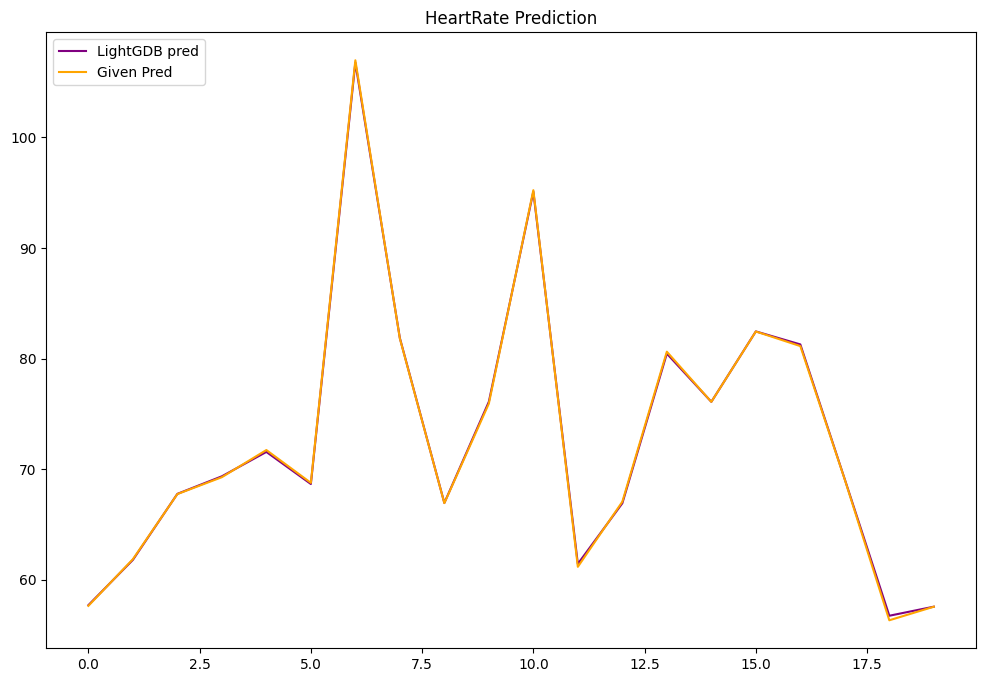

In [13]:
plt.figure(figsize=(12, 8))

plt.plot(range(0,20), pred_gdb[60:80], color = 'purple', label="LightGDB pred")
plt.plot(range(0,20), y_valid[60:80], color = 'orange', label="Given Pred")
plt.title("HeartRate Prediction")
plt.legend(loc="upper left")
plt.show()


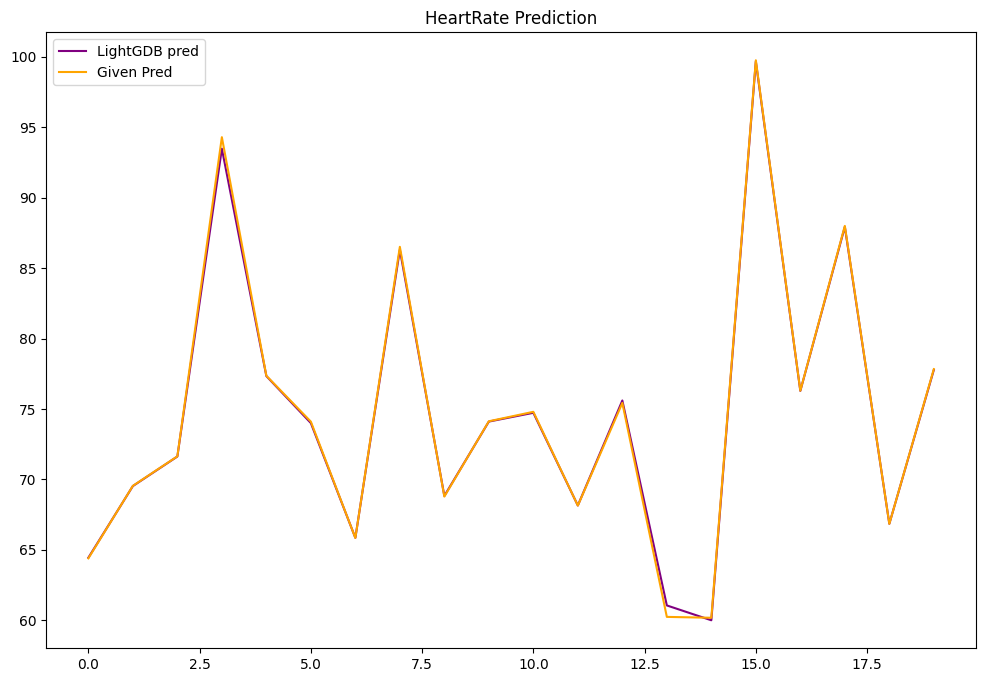

In [14]:
plt.figure(figsize=(12, 8))

plt.plot(range(0,20), pred_gdb[140:160], color = 'purple', label="LightGDB pred")
plt.plot(range(0,20), y_valid[140:160], color = 'orange', label="Given Pred")
plt.title("HeartRate Prediction")
plt.legend(loc="upper left")
plt.show()


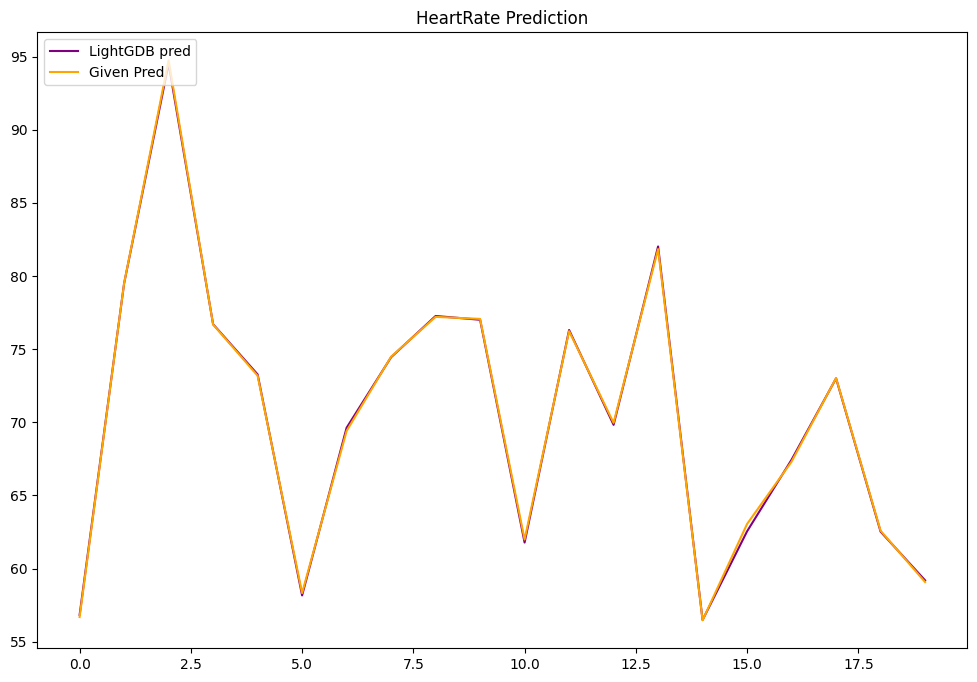

In [15]:
plt.figure(figsize=(12, 8))

plt.plot(range(0,20), pred_gdb[250:270], color = 'purple', label="LightGDB pred")
plt.plot(range(0,20), y_valid[250:270], color = 'orange', label="Given Pred")
plt.title("HeartRate Prediction")
plt.legend(loc="upper left")
plt.show()


In [11]:
loaded_lgb_model = lgb.Booster(model_file=model_filename_txt)
